##### Добавим виртуальную машину Gate.
VirtualBox Host-Only Ethernet Adapter  
192.168.51.5  
255.255.255.0  


|.|/|/|
|----------|-------------------------|--------------------------------------|
|Адаптер 1 |Виртуальный адаптер хоста|VirtualBox Host-Only Ethernet Adapter|
|Адаптер 2 |Сетевой мост | Realtek PCIe GBE Family Controller 2|


`ip a` -  lo, enp0s3, enp0s8  

##### /etc/network/interfaces
```
# This file describes the network interfaces available on your system 
# and how to activate them. For more information, see interfaces(5)/

source /etc/networк/interfaces.d/*

# The loopback network interface 

auto lo
iface lo inet loopback

# The primary network interface 
auto enp0s3
iface enp0s3 inet static 
address 192.168.51.1/24

# This section only for Server VM: 
#gateway 192.168.51.1 
#dns-nameservers 192.168.51.1 
#dns-search corpX.un

# The secondary network interface for Gate 
auto enp0s8

iface enp0s8 inet static 
address 192.168.1.104/24 
gateway 192.168.1.1 
dns-nameservers 192.168.1.1 
dns-search corp51.un
```
ifup enp0s3  
ifup enp0s8  
  

<details><summary>ip a</summary>
root@gate:~# ip a<br/>
1: lo: &lt;LOOPBACK,UP,LOWER_UP&gt; mtu 65536 qdisc noqueue state UNKNOWN group<br/> default qlen 1<br/>
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00<br/>
    inet 127.0.0.1/8 scope host lo<br/>
       valid_lft forever preferred_lft forever<br/>
    inet6 ::1/128 scope host<br/>
       valid_lft forever preferred_lft forever<br/>
2: enp0s3: &lt;BROADCAST,MULTICAST,UP,LOWER_UP&gt; mtu 1500 qdisc pfifo_fast state UP<br/> group default qlen 1000<br/>
    link/ether 08:00:27:c6:83:db brd ff:ff:ff:ff:ff:ff<br/>
    inet 192.168.51.1/24 brd 192.168.51.255 scope global enp0s3<br/>
       valid_lft forever preferred_lft forever<br/>
    inet6 fe80::a00:27ff:fec6:83db/64 scope link<br/>
       valid_lft forever preferred_lft forever<br/>
3: enp0s8: &lt;BROADCAST,MULTICAST,UP,LOWER_UP&gt; mtu 1500 qdisc pfifo_fast state UP<br/> group default qlen 1000<br/>
    link/ether 08:00:27:e8:64:63 brd ff:ff:ff:ff:ff:ff<br/>
    inet 192.168.1.104/24 brd 192.168.1.255 scope global enp0s8<br/>
       valid_lft forever preferred_lft forever<br/>
    inet6 fe80::a00:27ff:fee8:6463/64 scope link<br/>
       valid_lft forever preferred_lft forever<br/>
</details>

vim /etc/hostname  
vim /etc/hosts  


#### МОДУЛЬ 1. ДОБАВЛЕНИЕ МАРШРУТИЗАТОРА
`vim /etc/sysctl.conf` - sysctl preload/configuration file
  
```
# Uncomment the next line to enable packet forwarding for IPv4
net.ipv4.ip_forward=1
```
`sysctl -f` - net.ipv4.ip_forward = 1  
sysctl -f - Load   in   sysctl   settings   from   the   file  specified  or /etc/sysctl.conf  
`` -   


##### MASQUERADE
[Интернет-шлюз на базе Ubuntu Server / Internet Connection Sharing + Squid, Firestarter](https://help.ubuntu.ru/wiki/sharing_internet)  
[]() 
eth0-internet 192.168.1.0  enp0s8 192.168.1.0  
eth1-local 192.168.0.0 enp0s3 192.168.51.0  
`iptables -t nat -A POSTROUTING -o enp0s8 -j MASQUERADE` -   
`iptables-save > /etc/iptables.rules` -   
`vim /etc/network/interfaces` -   
`pre-up iptables-restore < /etc/iptables.rules` -   
```
up route add -net 192.168.51.0 netmask 255.255.255.0 dev enp0s3
up route add -net 0.0.0.0 netmask 255.255.255.255 dev enp0s8
```
`` -   
`` -   
`` -   



#### МОДУЛЬ 2. СЕРВИС DHCP


На виртуальной машине Gate:  
`apt install isc-dhcp-server` -   
`vim /etc/default/isc-dhcp-server` - INTERFACES="enp0s3"  
`vim /etc/dhcp/dhcpd.conf` - Настройка dhcp  
```
ddns-update-style none;
log-facility local7;
subnet 192.168.56.0 netmask 255.255.255.0 {
default-lease-time 600;
max-lease-time 7200;
range 192.168.56.101 192.168.56.199;
option routers 192.168.56.1;
option domain-name "corp56.un";
option domain-name-servers 192.168.56.1;
}
```  
`cp /etc/dhcp/dhcpd.conf /etc/dhcp/dhcpd01.conf` -   
`> /etc/dhcp/dhc` -   
`dhcpd -t` - Проверка  
```
root@gate:~# dhcpd -t
Internet Systems Consortium DHCP Server 4.3.3
Copyright 2004-2015 Internet Systems Consortium.
All rights reserved.
For info, please visit https://www.isc.org/software/dhcp/
Config file: /etc/dhcp/dhcpd.conf
Database file: /var/lib/dhcp/dhcpd.leases
PID file: /var/run/dhcpd.pid
```
`service start isc-dhcp-server` -   
`systemctl start isc-dhcp-server` -   
`tail -f /var/log/syslog` - Посмотреть результат  
```
Oct 19 14:29:32 gate dhcpd[1052]: DHCPREQUEST for 192.168.56.102 from 08:00:27:99:b1:5f (IE8WIN7) via enp0s3
Oct 19 14:29:32 gate dhcpd[1052]: DHCPACK on 192.168.56.102 to 08:00:27:99:b1:5f (IE8WIN7) via enp0s3
Oct 19 14:34:32 gate dhcpd[1052]: DHCPREQUEST for 192.168.56.102 from 08:00:27:99:b1:5f (IE8WIN7) via enp0s3
Oct 19 14:34:32 gate dhcpd[1052]: DHCPACK on 192.168.56.102 to 08:00:27:99:b1:5f (IE8WIN7) via enp0s3
Oct 19 14:34:38 gate systemd[1]: Started Session 3 of user root.
```
`tail -f /var/lib/dhcp/dhcpd.leases` -   
`less /var/lib/dhcp/dhcpd.leases` -   
```
root@gate:~# tail -f /var/lib/dhcp/dhcpd.leases
lease 192.168.56.102 {
  starts 6 2019/10/19 11:49:32;
  ends 6 2019/10/19 11:59:32;
  cltt 6 2019/10/19 11:49:32;
  binding state active;
  next binding state free;
  rewind binding state free;
  hardware ethernet 08:00:27:99:b1:5f;
  uid "\001\010\000'\231\261_";
  set vendor-class-identifier = "MSFT 5.0";
  client-hostname "IE8WIN7";
}
```
`` -   
`` -   
`` -   


##### Модуль 3. Доступ в Internet через HTTP Proxy

Установка squid на Ubuntu Server 16.04.02
На виртуальной машине Gate  
`apt install squid3` -   
`vim /etc/squid/squid.conf` - Настройка Squid 
```
#
# INSERT YOUR OWN RULE(S) HERE TO ALLOW ACCESS FROM YOUR CLIENTS
#

# Example rule allowing access from your local networks.
# Adapt localnet in the ACL section to list your (internal) IP networks
# from where browsing should be allowed
#http_access allow localnet
http_access allow localhost

acl our_networks src 192.168.56.0/24
http_access allow our_networks
```
`squid -k pars` - Проверка файла конфигурации  
`squid -k check` -   
`systemctl restart squid` -   
`netstat -apnt |grep squid` -  Print network connections, routing tables, interface statistics, masquerade connections, and multicast memberships  
tcp6       0      0 :::3128                 :::*                    LISTEN      2382/(squid-1)  
windesktop  
browser proxy server  
192.168.56.1:3128  
```

ps aux |grep squid

```
`` -   
`` -   
`` -   
`` -   
`` -   


```
Настройка IE в Windows:
3128 port for proxy
```

```
```

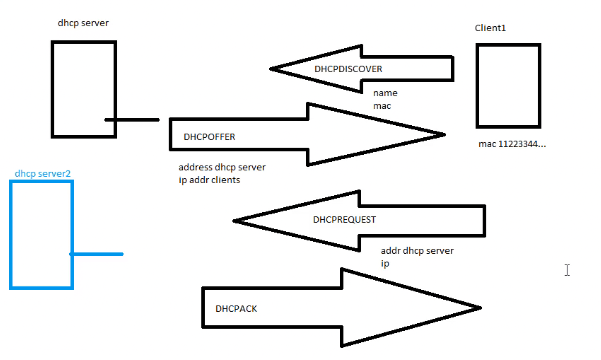

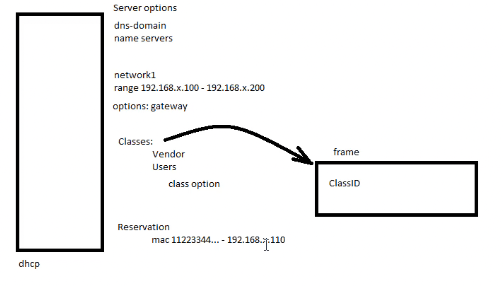

##### Модуль 9. Сервис Firewall
##### Настройка фильтра
`apt install conntrack` - command line interface for netfilter connection tracking  
`iptables-save` - dump iptables rules to stdout  
```
root@gate:~# iptables-save
# Generated by iptables-save v1.6.0 on Mon Oct 21 14:23:47 2019
*filter
:INPUT ACCEPT [178:23105]
:FORWARD ACCEPT [2089:175476]
:OUTPUT ACCEPT [1155:265687]
-A INPUT -p icmp -j ACCEPT
-A INPUT -p tcp -m state --state RELATED,ESTABLISHED -j ACCEPT
-A OUTPUT -p icmp -j ACCEPT
COMMIT
# Completed on Mon Oct 21 14:23:47 2019
```
`` -   

`vim firewall.sh` -   
`` -   
```
iptables --flush
iptables -A FORWARD -i enp0s3 -s 192.168.51.0/24 -j ACCEPT
iptables -A FORWARD -m conntrack --ctstate RELATED,ESTABLISHED -j ACCEPT
iptables -A INPUT -i lo -j ACCEPT
iptables -A INPUT -m conntrack --ctstate RELATED,ESTABLISHED -j ACCEPT
iptables -A FORWARD -j DROP
```
`sh firewall.sh` -   
`iptables-save` -   
```
root@gate:~# iptables-save
# Generated by iptables-save v1.6.0 on Mon Oct 21 16:14:34 2019
*filter
:INPUT ACCEPT [2:402]
:FORWARD ACCEPT [0:0]
:OUTPUT ACCEPT [12:1408]
-A INPUT -i lo -j ACCEPT
-A INPUT -m conntrack --ctstate RELATED,ESTABLISHED -j ACCEPT
-A FORWARD -s 192.168.51.0/24 -i enp0s3 -j ACCEPT
-A FORWARD -m conntrack --ctstate RELATED,ESTABLISHED -j ACCEPT
-A FORWARD -j DROP
COMMIT
# Completed on Mon Oct 21 16:14:34 2019
```
`route add -p 192.168.1.0 mask 255.255.0.0 10.5.5.31` -   
`iptables -t filter -n -L -v --line-numbers` -   
```
root@gate:~# iptables -t filter -n -L -v --line-numbers
Chain INPUT (policy ACCEPT 176 packets, 22446 bytes)
num   pkts bytes target     prot opt in     out     source               destination
1        0     0 ACCEPT     all  --  lo     *       0.0.0.0/0            0.0.0.0/0
2      248 21899 ACCEPT     all  --  *      *       0.0.0.0/0            0.0.0.0/0            ctstate RELATED,ESTABLISHED

Chain FORWARD (policy ACCEPT 0 packets, 0 bytes)
num   pkts bytes target     prot opt in     out     source               destination
1      619 51996 ACCEPT     all  --  enp0s3 *       192.168.51.0/24      0.0.0.0/0
2        0     0 ACCEPT     all  --  *      *       0.0.0.0/0            0.0.0.0/0            ctstate RELATED,ESTABLISHED
3        0     0 DROP       all  --  *      *       0.0.0.0/0            0.0.0.0/0

Chain OUTPUT (policy ACCEPT 225 packets, 34798 bytes)
num   pkts bytes target     prot opt in     out     source               destination
```
`conntrack -L` -   
`` -   
`` -   
`` -   
`` -   



#### LINUX UBUNTU. УРОВЕНЬ 2. ИСПОЛЬЗОВАНИЕ В КАЧЕСТВЕ СЕРВЕРОВ В INTERNET
#### ПРОГРАММА.
#### МОДУЛЬ 3. ДОСТУП В INTERNET ЧЕРЕЗ HTTP PROXY
#### МОДУЛЬ 4. СЕРВИС DNS - РАЗРЕШЕНИЕ ИМЕН
#### МОДУЛЬ 5. СЕРВИС ТОЧНОГО ВРЕМЕНИ
#### МОДУЛЬ 6. ФАЙЛОВЫЕ СЕРВИСЫ
#### МОДУЛЬ 7. СЕРВИС HTTP
#### МОДУЛЬ 8. СЕРВЕР ЭЛЕКТРОННОЙ ПОЧТЫ
#### МОДУЛЬ 9. FIREWALL. ЗАЩИТА СЕТИ
#### МОДУЛЬ 10. МОНИТОРИНГ ДОСТУПА В ИНТЕРНЕТ ЧЕРЕЗ SQUID


#### LINUX UBUNTU. УРОВЕНЬ 2. ИСПОЛЬЗОВАНИЕ В КАЧЕСТВЕ СЕРВЕРОВ В INTERNET
#### ПРОГРАММА.
#### МОДУЛЬ 1. ДОБАВЛЕНИЕ МАРШРУТИЗАТОРА
#### МОДУЛЬ 2. СЕРВИС DHCP
#### МОДУЛЬ 3. ДОСТУП В INTERNET ЧЕРЕЗ HTTP PROXY
#### МОДУЛЬ 4. СЕРВИС DNS - РАЗРЕШЕНИЕ ИМЕН
#### МОДУЛЬ 5. СЕРВИС ТОЧНОГО ВРЕМЕНИ
#### МОДУЛЬ 6. ФАЙЛОВЫЕ СЕРВИСЫ
#### МОДУЛЬ 7. СЕРВИС HTTP
#### МОДУЛЬ 8. СЕРВЕР ЭЛЕКТРОННОЙ ПОЧТЫ
#### МОДУЛЬ 9. FIREWALL. ЗАЩИТА СЕТИ
#### МОДУЛЬ 10. МОНИТОРИНГ ДОСТУПА В ИНТЕРНЕТ ЧЕРЕЗ SQUID


[Готовые виртуальные машины с Windows от Microsoft](https://www.white-windows.ru/gotovye-virtualnye-mashiny-s-windows-ot-microsoft/)  
[Download virtual machines](https://developer.microsoft.com/en-us/microsoft-edge/tools/vms/)  
[Поддержка русского языка в консоли](https://help.ubuntu.ru/wiki/russian_font_in_console)  
[Компактная версия Microsoft Windows 7 Ultimate x64](http://free-max.ru/1904-windows-7-ultimate-x64-by-kuloymin-v12-ru.html)  
[]()  
[]()  
